RL code

In [ ]:
!pip install stable_baselines3 shimmy>=0.2.1

In [ ]:
import numpy as np
import yfinance as yf
import gym
from gym import spaces

class PortfolioOptimizationEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    spec = gym.envs.registration.EnvSpec(id='PortfolioOptimizationEnv-v0')  # Required for custom environments

    def __init__(self, tickers, start_date, end_date, window=150, max_allocation=0.3, transaction_cost_rate=0.001):
        super(PortfolioOptimizationEnv, self).__init__()
        self.tickers = tickers
        self.num_assets = len(tickers)
        self.start_date = start_date
        self.end_date = end_date
        self.window = window
        self.max_allocation = max_allocation
        self.transaction_cost_rate = transaction_cost_rate

        # Fetch and preprocess data
        self.data = self.fetch_data()
        self.asset_prices = self.fetch_prices()
        self.initial_portfolio_value = 1.0  # Start with a portfolio value of $1

        # Adjust window size if necessary
        if len(self.data) <= self.window:
            self.window = len(self.data) - 1
            print(f"Adjusted env.window to {self.window} due to data length.")

        # Define action and observation space
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.num_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.window, self.num_assets), dtype=np.float32
        )

        self.current_step = self.window
        self.current_state = self.get_state()

        # Initialize portfolio
        self.allocations = np.ones(self.num_assets) / self.num_assets  # Start with equal allocations
        self.previous_portfolio_value = self.initial_portfolio_value
        self.portfolio_values = [self.initial_portfolio_value]
        self.max_portfolio_value = self.initial_portfolio_value

    def fetch_data(self):
        # Fetch historical returns data
        data = yf.download(self.tickers, start=self.start_date, end=self.end_date)["Adj Close"]
        data = data.ffill().bfill()
        returns = data.pct_change().dropna()
        returns = returns.replace([np.inf, -np.inf], np.nan).fillna(0)
        return returns

    def fetch_prices(self):
        # Fetch historical price data for calculating portfolio value
        data = yf.download(self.tickers, start=self.start_date, end=self.end_date)["Adj Close"]
        data = data.ffill().bfill()
        return data

    def get_state(self):
        # Use a rolling window of returns as the state
        rolling_returns = self.data.iloc[
            self.current_step - self.window : self.current_step
        ]
        # Fill any NaNs
        rolling_returns = rolling_returns.fillna(0)
        state = rolling_returns.values
        # Normalize observations manually
        state_mean = np.mean(state, axis=0)
        state_std = np.std(state, axis=0) + 1e-8  # Add epsilon to avoid division by zero
        state = (state - state_mean) / state_std
        # Ensure state is finite
        assert np.all(np.isfinite(state)), "Observation contains NaNs or Infs"
        return state

    def reset(self):
        self.current_step = self.window
        self.current_state = self.get_state()
        self.allocations = np.ones(self.num_assets) / self.num_assets  # Reset to equal allocations
        self.previous_portfolio_value = self.initial_portfolio_value
        self.portfolio_values = [self.initial_portfolio_value]
        self.max_portfolio_value = self.initial_portfolio_value
        return self.current_state

    def step(self, action):
        # Rescale actions from [-1, 1] to [0, 1]
        allocations = (action + 1) / 2
        # Limit allocations to prevent over-concentration
        allocations = np.clip(allocations, 0, self.max_allocation)
        allocations = allocations / np.sum(allocations)  # Ensure allocations sum to 1

        # Calculate transaction costs
        transaction_cost = self.transaction_cost_rate * np.sum(np.abs(allocations - self.allocations))
        self.allocations = allocations  # Update current allocations

        # Calculate portfolio return
        next_state_returns = self.data.iloc[self.current_step].values
        portfolio_return = np.dot(self.allocations, next_state_returns)
        self.previous_portfolio_value *= (1 + portfolio_return)
        self.portfolio_values.append(self.previous_portfolio_value)
        self.max_portfolio_value = max(self.max_portfolio_value, self.previous_portfolio_value)
        drawdown = (self.max_portfolio_value - self.previous_portfolio_value) / self.max_portfolio_value

        # Calculate volatility
        if len(self.portfolio_values) > 1:
            volatility = np.std(self.portfolio_values[-20:])  # Use last 20 portfolio values
        else:
            volatility = 0

        # Calculate reward based on Sharpe Ratio and drawdown penalty
        reward = self.calculate_reward(portfolio_return, volatility, drawdown, transaction_cost)

        # Advance to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        next_state = self.get_state() if not done else None

        # Logging for analysis
        info = {
            'portfolio_value': self.previous_portfolio_value,
            'portfolio_return': portfolio_return,
            'volatility': volatility,
            'drawdown': drawdown,
            'transaction_cost': transaction_cost,
            'allocations': self.allocations.copy()
        }

        return next_state, reward, done, info

    def calculate_reward(self, portfolio_return, volatility, drawdown, transaction_cost):
        # Use Sharpe Ratio and penalize drawdown and transaction costs
        if volatility != 0:
            sharpe_ratio = portfolio_return / volatility
        else:
            sharpe_ratio = 0
        reward = sharpe_ratio - 0.5 * drawdown - transaction_cost
        return reward

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env

# Define the environment
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
env = PortfolioOptimizationEnv(tickers, "2010-01-01", "2020-01-01")
vec_env = make_vec_env(
    lambda: PortfolioOptimizationEnv(tickers, "2010-01-01", "2020-01-01"), n_envs=1
)

# Adjust policy parameters
policy_kwargs = dict(
    log_std_init=-3,
    net_arch=dict(pi=[256, 256], qf=[256, 256])  # Two hidden layers with 256 neurons each
)

# Create SAC model with adjusted hyperparameters
model = SAC(
    "MlpPolicy",
    vec_env,
    verbose=1,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-4,
    batch_size=256,
    ent_coef='auto',
    target_entropy='auto',
    tensorboard_log="./sac_portfolio_tensorboard/"
)

# Train the model
model.learn(total_timesteps=250000, log_interval=4)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
<ipython-input-2-c4347ba40f8f>:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
<ipython-input-2-c4347ba40f8f>:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and

Using cuda device
Logging to ./sac_portfolio_tensorboard/SAC_1


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24e+03 |
|    ep_rew_mean     | 4.24     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 76       |
|    time_elapsed    | 116      |
|    total_timesteps | 8968     |
| train/             |          |
|    actor_loss      | -73      |
|    critic_loss     | 0.101    |
|    ent_coef        | 0.412    |
|    ent_coef_loss   | -7.47    |
|    learning_rate   | 0.0001   |
|    n_updates       | 8867     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24e+03 |
|    ep_rew_mean     | 4.44     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 77       |
|    time_elapsed    | 232      |
|    total_timesteps | 17936    |
| train/             |          |
|    actor_loss      | -75.5    |
|    critic_loss     | 0.0651   |
|    ent_coef 

In [ ]:
import numpy as np

# Function to retrieve SAC model allocations
def get_sac_allocations(model, state):
    action, _ = model.predict(state)
    allocations = (action + 1) / 2  # Rescale actions to [0, 1]
    allocations = np.clip(allocations, 0, env.max_allocation)  # Apply max allocation constraint
    allocations = allocations / np.sum(allocations)  # Ensure allocations sum to 1
    return action, allocations

def apply_sac_policy(tickers, model, env):
    state = env.reset()
    done = False
    allocations_history = []
    portfolio_values = []
    states_array = []  # Initialize states_array to store each state

    while not done:
        action, allocations = get_sac_allocations(model, state)
        next_state, reward, done, info = env.step(action)

        allocations_history.append({
            "allocations": allocations.copy(),
            "reward": reward,
            "portfolio_value": info['portfolio_value'],
            "portfolio_return": info['portfolio_return'],
            "volatility": info['volatility'],
            "drawdown": info['drawdown'],
            "transaction_cost": info['transaction_cost']
        })

        portfolio_values.append(info['portfolio_value'])
        states_array.append(state)  # Store each state in states_array

        state = next_state

    return allocations_history, portfolio_values, states_array

# Run SAC model and retrieve allocation history
allocations_history, portfolio_values, states_array = apply_sac_policy(tickers, model, env)

[*********************100%***********************]  5 of 5 completed



SAC Backtesting Results:
Total Return: 739.65%
Annualized Return: 27.02%
Annualized Volatility: 23.94%
Sharpe Ratio: 1.13
Max Drawdown: 25.46%


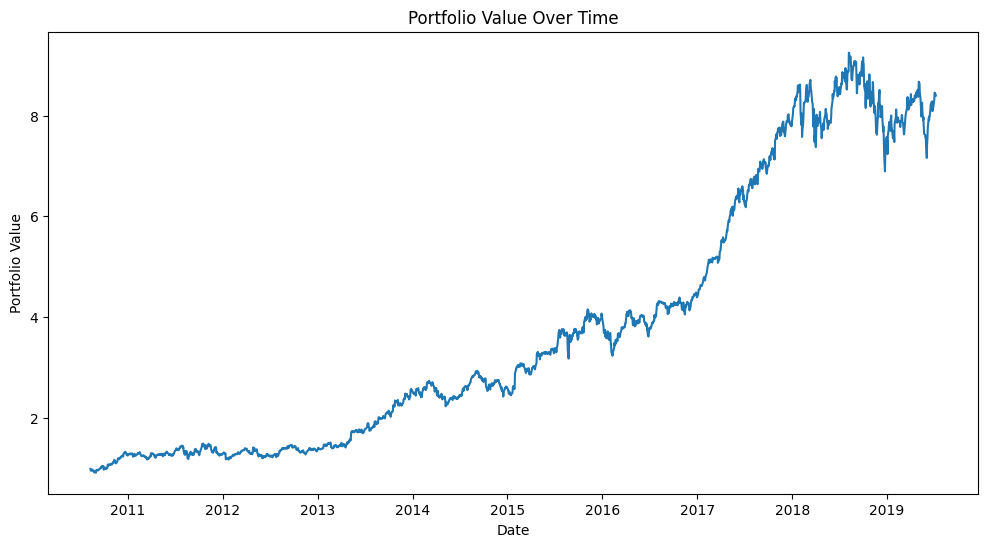

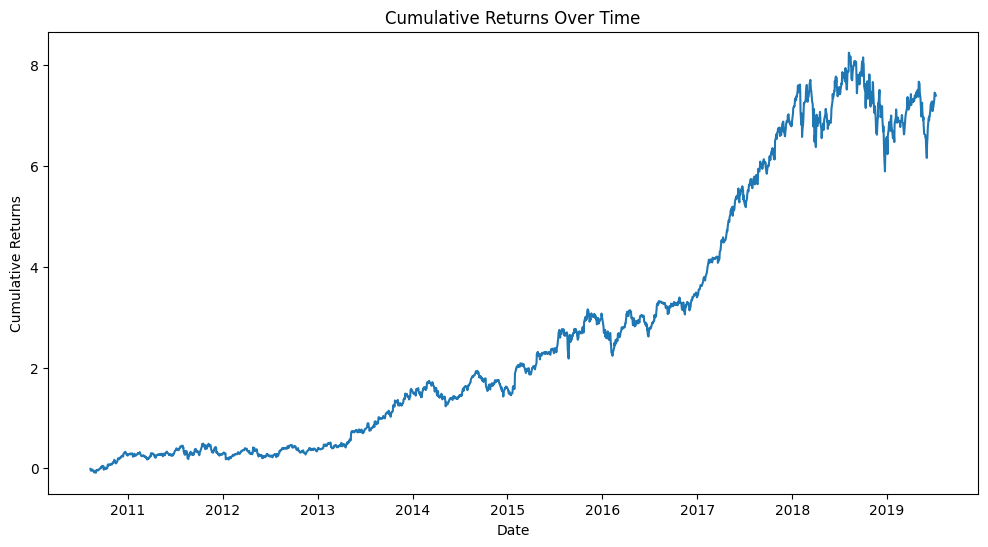

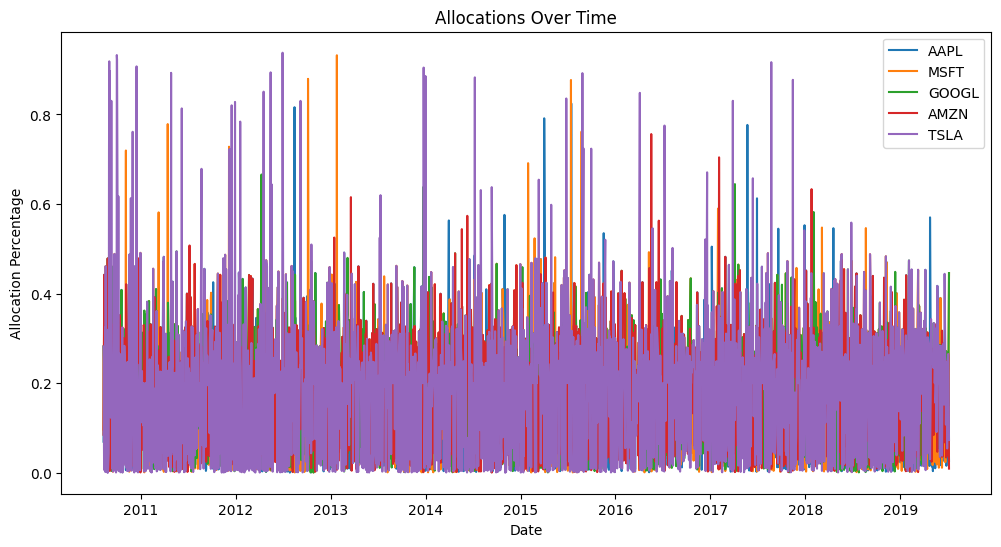

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define data fetching function for backtesting
def fetch_data(tickers, start_date="2010-01-01", end_date="2020-01-01"):
    data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
    data = data.ffill().bfill()
    returns = data.pct_change().dropna()
    returns = returns.replace([np.inf, -np.inf], np.nan).fillna(0)
    return returns

def backtest_sac_portfolio(allocations_history, returns_data):
    # Align dates with backtesting period
    start_index = env.window  # Starting index in returns_data
    dates = returns_data.index[start_index:start_index + len(allocations_history)]
    portfolio_returns = []
    portfolio_values = []
    portfolio_value = env.initial_portfolio_value

    for i, record in enumerate(allocations_history):
        date = dates[i]
        daily_return = returns_data.iloc[start_index + i]
        portfolio_return = np.dot(record["allocations"], daily_return)
        portfolio_value *= (1 + portfolio_return)
        portfolio_returns.append(portfolio_return)
        portfolio_values.append(portfolio_value)

    portfolio_returns = np.array(portfolio_returns)
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    cumulative_returns = np.nan_to_num(cumulative_returns, nan=0.0)
    annualized_return = (
        (1 + cumulative_returns[-1]) ** (252 / len(portfolio_returns)) - 1
        if len(portfolio_returns) > 0
        else 0
    )
    annualized_volatility = (
        np.std(portfolio_returns) * np.sqrt(252) if len(portfolio_returns) > 1 else 0
    )
    sharpe_ratio = (
        annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    )

    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values) / np.max(portfolio_values)

    print("\nSAC Backtesting Results:")
    print(f"Total Return: {cumulative_returns[-1]:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot portfolio value over time
    plt.figure(figsize=(12, 6))
    plt.plot(dates, portfolio_values)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(dates, cumulative_returns)
    plt.title('Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.show()

    # Plot allocations over time
    allocations_array = np.array([record['allocations'] for record in allocations_history])
    plt.figure(figsize=(12, 6))
    for i, ticker in enumerate(tickers):
        plt.plot(dates, allocations_array[:, i], label=ticker)
    plt.title('Allocations Over Time')
    plt.xlabel('Date')
    plt.ylabel('Allocation Percentage')
    plt.legend()
    plt.show()

# Run backtest
returns_data = fetch_data(tickers, start_date="2010-01-01", end_date="2020-01-01")
backtest_sac_portfolio(allocations_history, returns_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


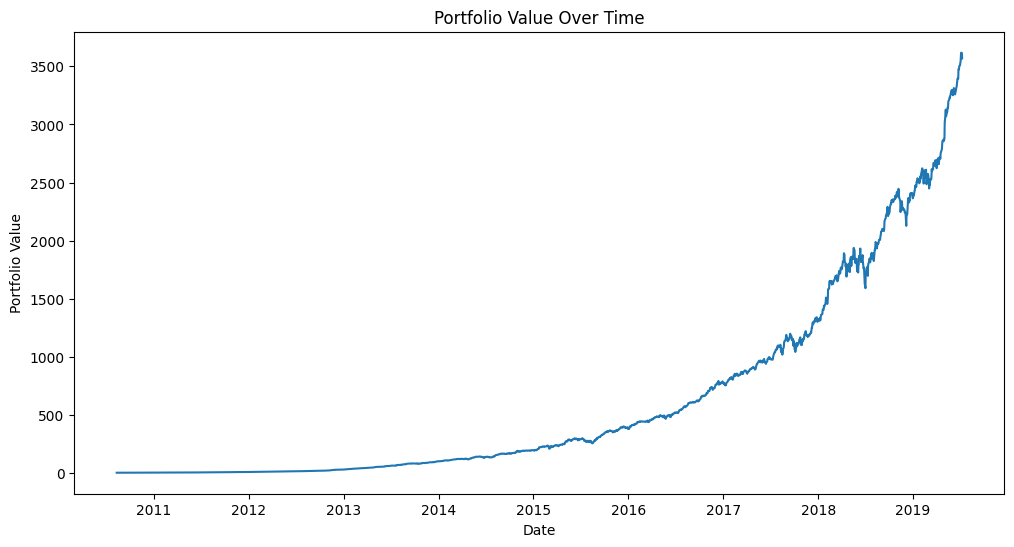

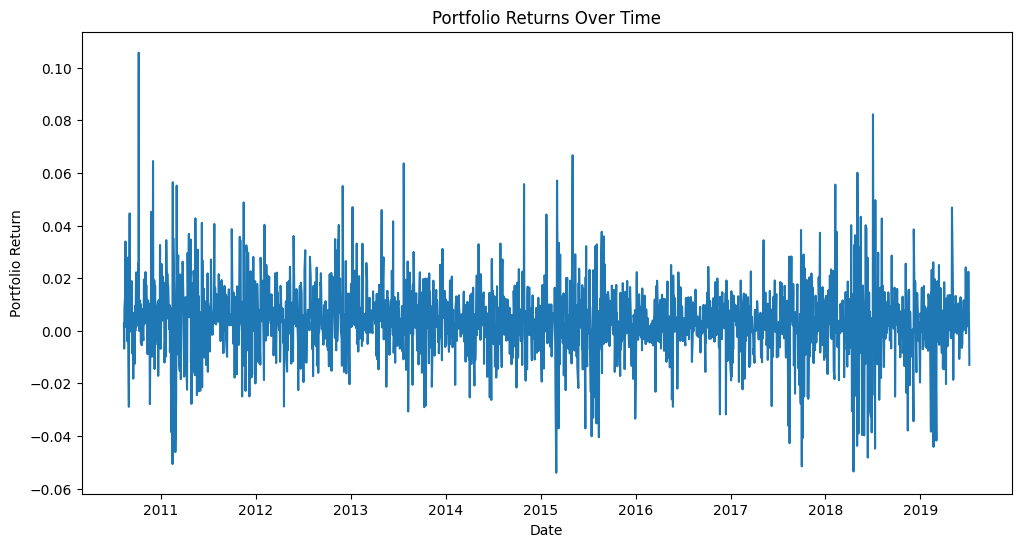

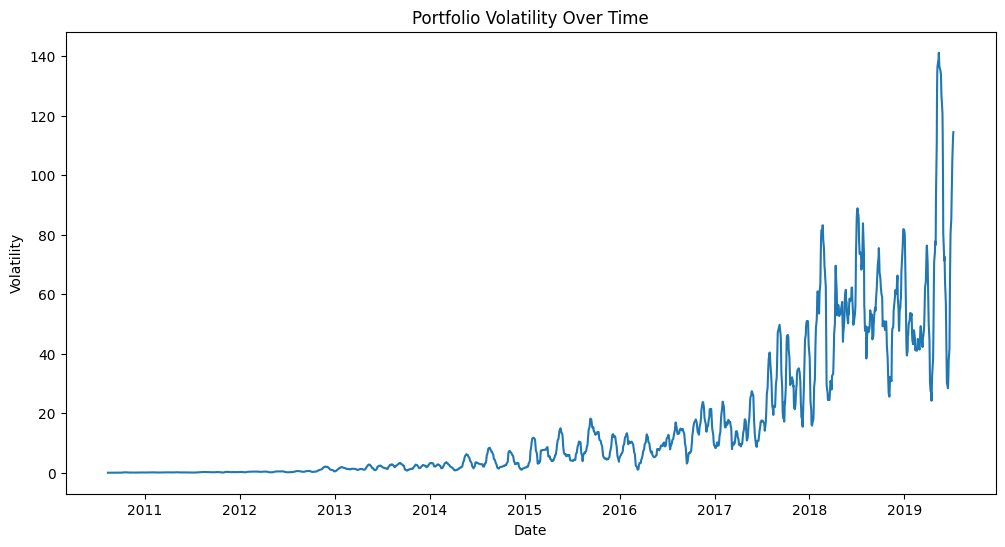

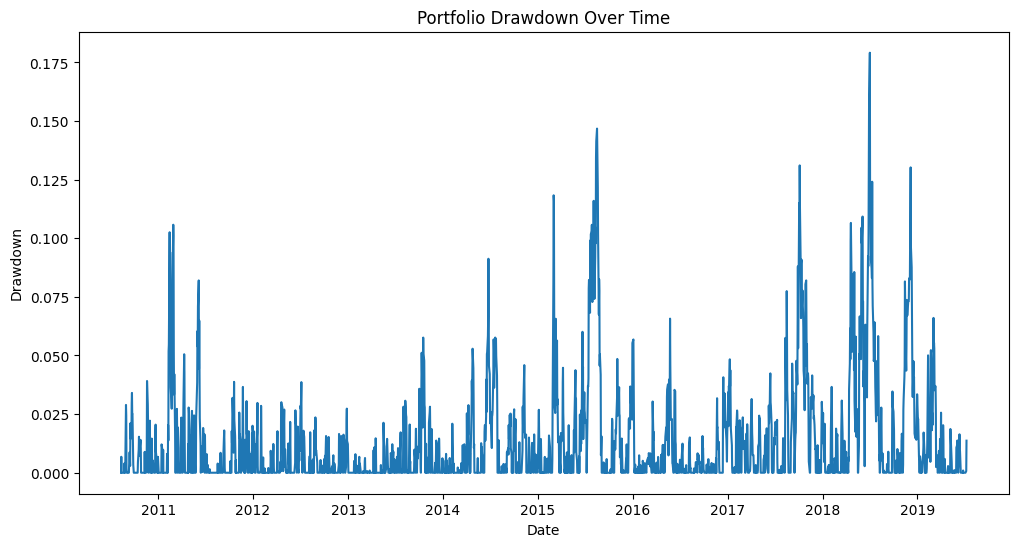

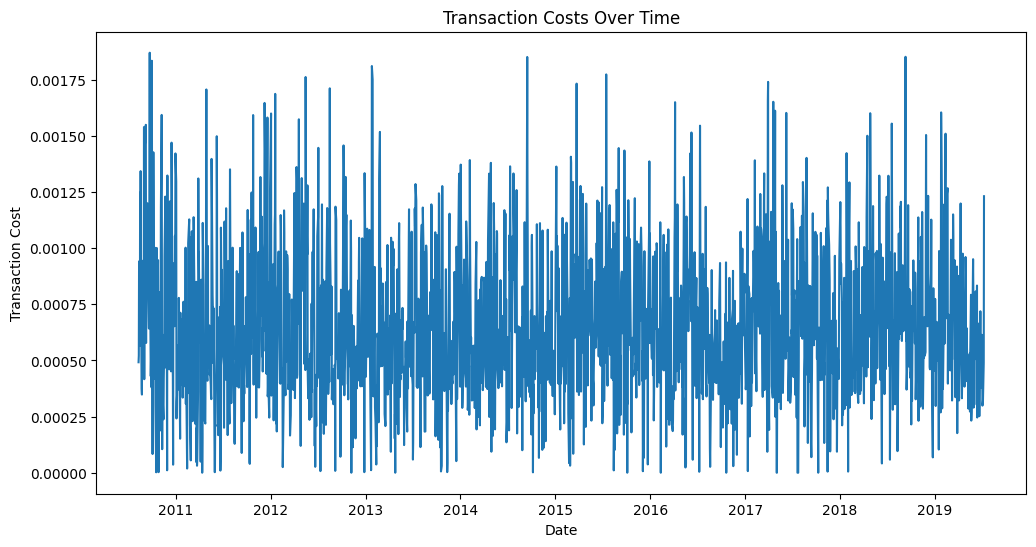

Allocations on 2019-07-09:
AAPL: 2.62%
MSFT: 44.58%
GOOGL: 44.58%
AMZN: 0.92%
TSLA: 7.31%


In [ ]:
# Analyze agent's behavior
import pandas as pd

# Create a DataFrame from allocations_history
df_allocations = pd.DataFrame(allocations_history)
dates = returns_data.index[env.window+1:]
df_allocations['Date'] = dates[:len(df_allocations)]

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(df_allocations['Date'], df_allocations['portfolio_value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

# Plot portfolio returns over time
plt.figure(figsize=(12, 6))
plt.plot(df_allocations['Date'], df_allocations['portfolio_return'])
plt.title('Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.show()

# Plot volatility over time
plt.figure(figsize=(12, 6))
plt.plot(df_allocations['Date'], df_allocations['volatility'])
plt.title('Portfolio Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

# Plot drawdown over time
plt.figure(figsize=(12, 6))
plt.plot(df_allocations['Date'], df_allocations['drawdown'])
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()

# Plot transaction costs over time
plt.figure(figsize=(12, 6))
plt.plot(df_allocations['Date'], df_allocations['transaction_cost'])
plt.title('Transaction Costs Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Cost')
plt.show()

# Examine allocations at a specific date
date_to_examine = df_allocations['Date'].iloc[-1]
allocations_at_date = df_allocations.loc[df_allocations['Date'] == date_to_examine, 'allocations'].values[0]
print(f"Allocations on {date_to_examine.date()}:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {allocations_at_date[i]:.2%}")

New code

In [ ]:
# Analyze agent's behavior and print monthly allocations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame from allocations_history
df_allocations = pd.DataFrame(allocations_history)

# Use the dates from the environment's data
start_index = env.window  # Starting index in returns_data
dates = env.data.index[start_index:start_index + len(df_allocations)]
df_allocations['Date'] = dates
df_allocations['Date'] = pd.to_datetime(df_allocations['Date'])
df_allocations.set_index('Date', inplace=True)

# Expand the 'allocations' column into separate columns for each ticker
allocations_array = np.vstack(df_allocations['allocations'].values)
allocations_df = pd.DataFrame(allocations_array, columns=tickers, index=df_allocations.index)

# Resample allocations to monthly frequency, taking the last allocation of each month
monthly_allocations = allocations_df.resample('M').last()

# Convert allocations to percentages
monthly_allocations_percent = monthly_allocations * 100

# Round the percentages for better readability
monthly_allocations_percent = monthly_allocations_percent.round(2)

# Print the monthly allocations
print("Monthly Allocations:")
for date, row in monthly_allocations_percent.iterrows():
    print(f"\nAllocations on {date.strftime('%Y-%m')}:")
    for ticker in tickers:
        print(f"  {ticker}: {row[ticker]:.2f}%")

Monthly Allocations:

Allocations on 2011-02:
  AAPL: 25.93%
  MSFT: 1.71%
  GOOGL: 25.93%
  AMZN: 25.93%
  TSLA: 20.50%

Allocations on 2011-03:
  AAPL: 20.82%
  MSFT: 12.63%
  GOOGL: 3.22%
  AMZN: 1.60%
  TSLA: 61.72%

Allocations on 2011-04:
  AAPL: 32.18%
  MSFT: 32.18%
  GOOGL: 32.18%
  AMZN: 1.87%
  TSLA: 1.59%

Allocations on 2011-05:
  AAPL: 23.06%
  MSFT: 23.06%
  GOOGL: 23.06%
  AMZN: 7.75%
  TSLA: 23.06%

Allocations on 2011-06:
  AAPL: 22.72%
  MSFT: 9.14%
  GOOGL: 22.72%
  AMZN: 22.72%
  TSLA: 22.72%

Allocations on 2011-07:
  AAPL: 24.34%
  MSFT: 24.34%
  GOOGL: 24.34%
  AMZN: 24.34%
  TSLA: 2.65%

Allocations on 2011-08:
  AAPL: 4.45%
  MSFT: 27.30%
  GOOGL: 27.30%
  AMZN: 27.30%
  TSLA: 13.64%

Allocations on 2011-09:
  AAPL: 31.01%
  MSFT: 3.61%
  GOOGL: 3.36%
  AMZN: 31.01%
  TSLA: 31.01%

Allocations on 2011-10:
  AAPL: 29.51%
  MSFT: 10.33%
  GOOGL: 29.51%
  AMZN: 29.51%
  TSLA: 1.15%

Allocations on 2011-11:
  AAPL: 20.00%
  MSFT: 20.00%
  GOOGL: 20.00%
  AMZN: 20.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-7-d8606c1bedc3>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_allocations = allocations_df.resample('M').last()


Computing SHAP values...


PermutationExplainer explainer: 2243it [1:14:24,  2.00s/it]


Adjusted shap_values_selected shape: (2242, 750)
states_reshaped shape: (2242, 750)
Number of feature names: 750


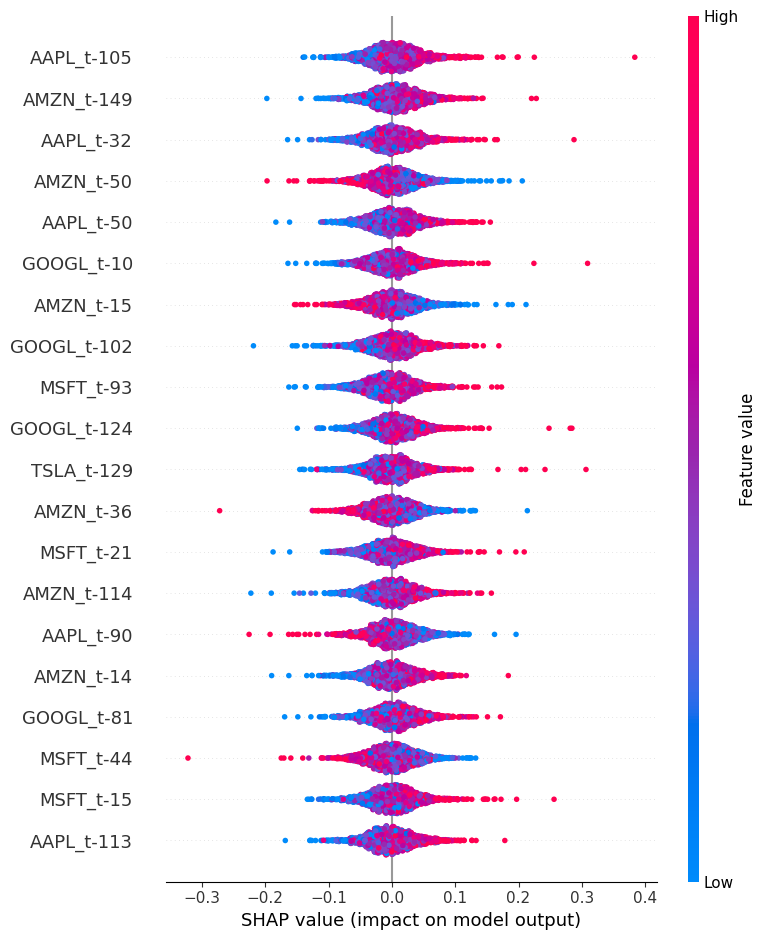

In [ ]:
# Cell 8: SHAP Values for Explainable AI
import shap
import torch

# Convert states to torch tensors
# Convert states_array to a numpy array
states_array = np.array(states_array)
state_tensor = torch.tensor(states_array, dtype=torch.float32)

# If necessary, flatten the state tensor
state_tensor = state_tensor.view(state_tensor.size(0), -1)

# Adjust policy_predict to handle device placement
def policy_predict(input_data):
    # Convert input to torch tensor and move it to the same device as the policy network
    input_tensor = torch.tensor(input_data, dtype=torch.float32)
    device = model.policy.actor.device  # Get the policy network's device
    input_tensor = input_tensor.to(device)

    # Reshape input to match the model's expected input shape
    input_tensor = input_tensor.view(-1, env.window, env.num_assets)

    # Get actions from the policy network
    with torch.no_grad():
        actions = model.policy.actor(input_tensor)
    return actions.cpu().numpy()  # Move output to CPU for compatibility with SHAP

# Determine the number of features in each state
num_features = state_tensor.shape[1]

# Convert state_tensor to a NumPy array for use with SHAP
state_numpy = state_tensor.numpy()

# Use Independent masker with the NumPy array as the background dataset
masker = shap.maskers.Independent(state_numpy)

# Set up the SHAP explainer with the specified masker and max_evals
explainer = shap.Explainer(policy_predict, masker, algorithm="permutation", max_evals=(2 * num_features + 1))

# Compute SHAP values using state_numpy instead of state_tensor
print("Computing SHAP values...")
shap_values = explainer(state_numpy)

# Extract SHAP values
shap_values_array = shap_values.values

# Select only the first output dimension from shap_values_array to match states_reshaped
shap_values_selected = shap_values_array[:, :, 0]  # Use the first output for simplicity

# Create feature names
window_size = env.window
feature_names = []
for i in range(window_size):
    for ticker in tickers:
        feature_names.append(f"{ticker}_t-{window_size - i}")

# Reshape states_array to 2D for plotting
states_reshaped = states_array.reshape(states_array.shape[0], -1)

# Verify dimensions
print("Adjusted shap_values_selected shape:", shap_values_selected.shape)
print("states_reshaped shape:", states_reshaped.shape)
print("Number of feature names:", len(feature_names))

# Adjust feature names if needed
if states_reshaped.shape[1] != len(feature_names):
    feature_names = feature_names[:states_reshaped.shape[1]]

# Plot the SHAP summary plot
shap.summary_plot(shap_values_selected, states_reshaped, feature_names=feature_names, max_display=20)

Most important feature index: 225


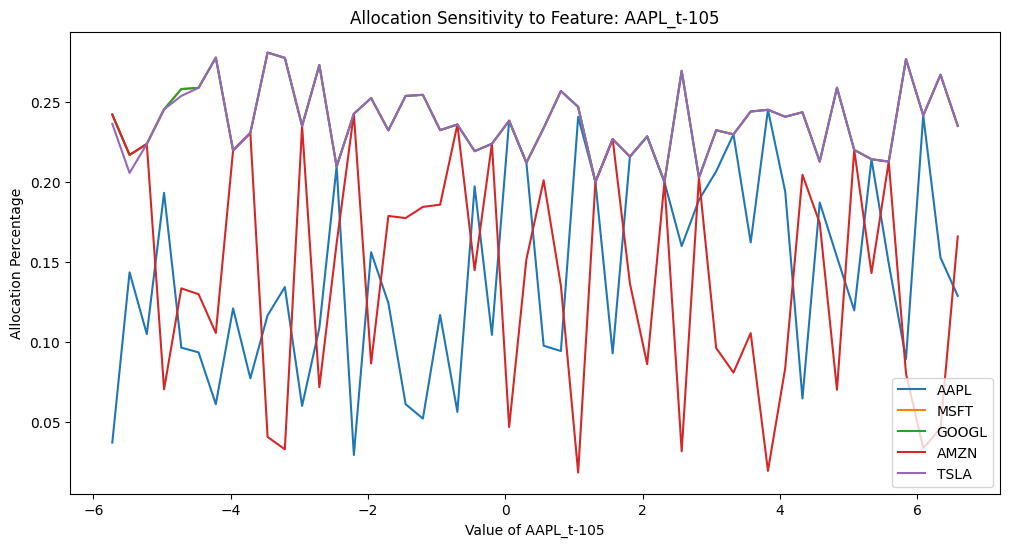

In [ ]:
# Cell 8: Feature Importance and Sensitivity Analysis
import matplotlib.pyplot as plt

# Select a sample state to analyze
sample_state = states_array[0]  # You can choose any state from states_array

# Reshape sample_state to match the input shape expected by the model
sample_state = sample_state.reshape(1, -1)

# Define a function to perturb a feature and observe the change in allocations
def perturb_feature_and_get_allocations(state, feature_index, feature_range):
    allocations = []
    for value in feature_range:
        perturbed_state = state.copy()
        perturbed_state[0, feature_index] = value
        action, _ = model.predict(perturbed_state.reshape(env.window, env.num_assets), deterministic=True)
        _, allocation = get_sac_allocations(model, perturbed_state.reshape(env.window, env.num_assets))
        allocations.append(allocation)
    return allocations

# Choose a feature to perturb (e.g., the most important feature from SHAP analysis)
# For this example, we'll perturb the most important feature

# Calculate feature importance using only the relevant dimension of shap_values_array
# Assuming shap_values_array has the shape (num_samples, num_features, num_outputs)
# Select the first output dimension, or slice it if you need another one
feature_importance = np.abs(shap_values_array[:, :, 0]).mean(axis=0)

# Get the index of the most important feature within the bounds of states_reshaped
most_important_feature_index = np.argmax(feature_importance)
print(f"Most important feature index: {most_important_feature_index}")

# Define the range of values to test for the selected feature
feature_min = states_reshaped[:, most_important_feature_index].min()
feature_max = states_reshaped[:, most_important_feature_index].max()
feature_range = np.linspace(feature_min, feature_max, 50)

# Perform perturbation analysis
allocations = perturb_feature_and_get_allocations(sample_state, most_important_feature_index, feature_range)

# Convert allocations to a numpy array
allocations = np.array(allocations)

# Plot how allocations change with the perturbed feature
plt.figure(figsize=(12, 6))
for i, ticker in enumerate(tickers):
    plt.plot(feature_range, allocations[:, i], label=ticker)
plt.title(f'Allocation Sensitivity to Feature: {feature_names[most_important_feature_index]}')
plt.xlabel(f'Value of {feature_names[most_important_feature_index]}')
plt.ylabel('Allocation Percentage')
plt.legend()
plt.show()